In [1]:
%%capture
%load_ext autoreload
%autoreload 2

In [24]:
import itertools
from typing import Any, Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from collinearity import SelectNonCollinear

from utils import (
    METRIC_COLUMNS,
    ROOTDIR,
    AdjacencyMethod,
    DistanceTransformation,
    Normalizer,
    encode_variables_to_filename,
    get_dataset_filename,
    setup_plotting,
)

setup_plotting()

## Choose configuration

Depending on the configuration desired, we get the dataset

In [15]:
def h0_condition(p_values: pd.Series, alpha: float = 0.09) -> pd.Series:
    return p_values < alpha


def get_model_summary_statistics(
    x: np.ndarray,
    y: np.ndarray,
) -> Dict[str, Any]:
    x = sm.add_constant(x)  # Adds a constant term to the predictor
    model = sm.OLS(y, x).fit()

    summary = model.summary2().tables[1]
    p_values = summary["P>|t|"].drop("const")
    h0_count = p_values[h0_condition(p_values)].count()
    return {
        "model": model,
        "summary": summary,
        "h0_count": h0_count,
    }


def get_summary_statistics(
    dataset_conf: pd.DataFrame,
    transformation: DistanceTransformation,
    norm_method: Normalizer,
    adjacency_method: AdjacencyMethod,
    event_filename: str,
    input_data: bool,
    use_threshold: bool,
) -> Dict[str, Any]:
    df0 = dataset_conf[
        (dataset_conf["transformation"] == transformation.value)
        & (dataset_conf["normalization"] == norm_method.value)
        & (dataset_conf["adjacency_method"] == adjacency_method.value)
    ].sort_values(by="intensity")[[*METRIC_COLUMNS, "intensity"]]

    x0 = df0.drop(columns=["intensity"]).astype(float).values
    y = (
        df0["intensity"]
        .replace(
            ["G1", "G2", "G3", "G4", "G5", "Unknown", np.nan, "G4/G5", "G3/G4"],
            [1, 2, 3, 4, 5, 0, 0, 4.5, 3.5],
        )
        .astype(float)
        .values
    )

    try:
        summary_statistics = get_model_summary_statistics(x0, y)  # type: ignore
        model = summary_statistics["model"]
        h0_count = summary_statistics["h0_count"]
    except Exception as e:
        dataset_name = encode_variables_to_filename(
            event_filename=event_filename,
            imput_data=input_data,
            use_threshold=use_threshold,
        )
        print(f"Error processing dataset: {dataset_name} -- {e}")
        print(
            f"transformation={transformation.value}, normalization={norm_method.value}, "
            f"adjacency_method={adjacency_method.value}"
        )

        raise e

    return {
        "df0": df0,
        "model": model,
        "count": h0_count,
    }

### Bests configurations?

Trying to do grid search, and take the bests combinations, what is the best combination? In this case, I'll take those combinations with the mosts amount of variables < 0.09, and save it in a .csv to read it later

In [ ]:
dataset_combinations = list(
    itertools.product(
        ["all.txt", "all.original.txt", "all.imp.txt"],
        [False, True],  # input_data == use_threshold
    )
)
combinations_per_dataset = list(
    itertools.product(
        DistanceTransformation,
        Normalizer,
        [AdjacencyMethod.MANHATTAN, AdjacencyMethod.MINKOWSKI],
    )
)

dataset = {
    "event_filename": [],
    "input_data": [],
    "use_threshold": [],
    "transformation": [],
    "normalization": [],
    "adjacency_method": [],
    "count": [],
}
for event_filename, input_data in dataset_combinations:
    use_threshold = input_data
    dataset_conf = get_dataset_filename(
        event_filename=event_filename,
        input_data=input_data,
        use_threshold=use_threshold,
    )
    print(
        "Processing dataset: "
        f"{encode_variables_to_filename(event_filename, input_data, use_threshold)}"
    )

    for transformation, norm_method, adjacency_method in combinations_per_dataset:
        results = get_summary_statistics(
            dataset_conf=dataset_conf,
            transformation=transformation,
            norm_method=norm_method,
            adjacency_method=adjacency_method,
            event_filename=event_filename,
            input_data=input_data,
            use_threshold=use_threshold,
        )
        h0_count = results["count"]

        dataset["event_filename"].append(event_filename)
        dataset["input_data"].append(input_data)
        dataset["use_threshold"].append(use_threshold)
        dataset["transformation"].append(transformation.value)
        dataset["normalization"].append(norm_method.value)
        dataset["adjacency_method"].append(adjacency_method.value)
        dataset["count"].append(int(h0_count))

dataset_df = pd.DataFrame(dataset)
dataset_df.to_csv(ROOTDIR / "data" / "dataset_summary.csv", index=False)

## Read best configurations

In [5]:
dataset_df = pd.read_csv(
    ROOTDIR / "data" / "dataset_summary.csv", index_col=False
).sort_values(by="count", ascending=False)

dataset_df

,event_filename,input_data,use_threshold,transformation,normalization,adjacency_method,count
140,all.imp.txt,False,False,exponential,min_max,manhattan,4
170,all.imp.txt,True,True,exponential,min_max,manhattan,4
68,all.original.txt,False,False,none,none,manhattan,4
52,all.txt,True,True,exponential,z_score,manhattan,4
84,all.original.txt,False,False,exponential,robust,manhattan,3
...,...,...,...,...,...,...,...
167,all.imp.txt,True,True,log,decimal_scaling,minkowski,0
175,all.imp.txt,True,True,exponential,robust,minkowski,0
172,all.imp.txt,True,True,exponential,z_score,manhattan,0
177,all.imp.txt,True,True,exponential,decimal_scaling,minkowski,0


In [6]:
for row in dataset_df.head(5).itertuples():
    event_filename = str(row.event_filename)
    input_data = bool(row.input_data)
    use_threshold = bool(row.use_threshold)
    transformation = row.transformation
    normalization = row.normalization
    adjacency_method = row.adjacency_method

    dataset_conf = get_dataset_filename(
        event_filename=event_filename,
        input_data=input_data,
        use_threshold=use_threshold,
    )

    model = get_summary_statistics(
        dataset_conf=dataset_conf,
        transformation=DistanceTransformation(transformation),
        norm_method=Normalizer(normalization),
        adjacency_method=AdjacencyMethod(adjacency_method),
        event_filename=event_filename,
        input_data=input_data,
        use_threshold=use_threshold,
    )["model"]

    print(
        "Dataset name: "
        f"{encode_variables_to_filename(event_filename, input_data, use_threshold)}"
    )
    print(
        f"Transformation: {transformation}, Normalization: {normalization}, "
        f"Adjacency Method: {adjacency_method}"
    )
    print(model.summary())

    print("\n\n")

Dataset name: dataset_all.imp_imput-False_threshold-False.csv
Transformation: exponential, Normalization: min_max, Adjacency Method: manhattan
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     1.129
Date:                Tue, 10 Feb 2026   Prob (F-statistic):              0.386
Time:                        00:28:56   Log-Likelihood:                -34.631
No. Observations:                  34   AIC:                             93.26
Df Residuals:                      22   BIC:                             111.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025 

## Take particular configuration

In [ ]:
event_filename = "all.txt"
input_data = True
use_threshold = True
transformation = "exponential"
normalization = "z_score"
adjacency_method = "manhattan"

dataset_conf = get_dataset_filename(
    event_filename=event_filename,
    input_data=input_data,
    use_threshold=use_threshold,
)

results = get_summary_statistics(
    dataset_conf,
    DistanceTransformation(transformation),
    Normalizer(normalization),
    AdjacencyMethod(adjacency_method),
    event_filename,
    input_data,
    use_threshold,
)

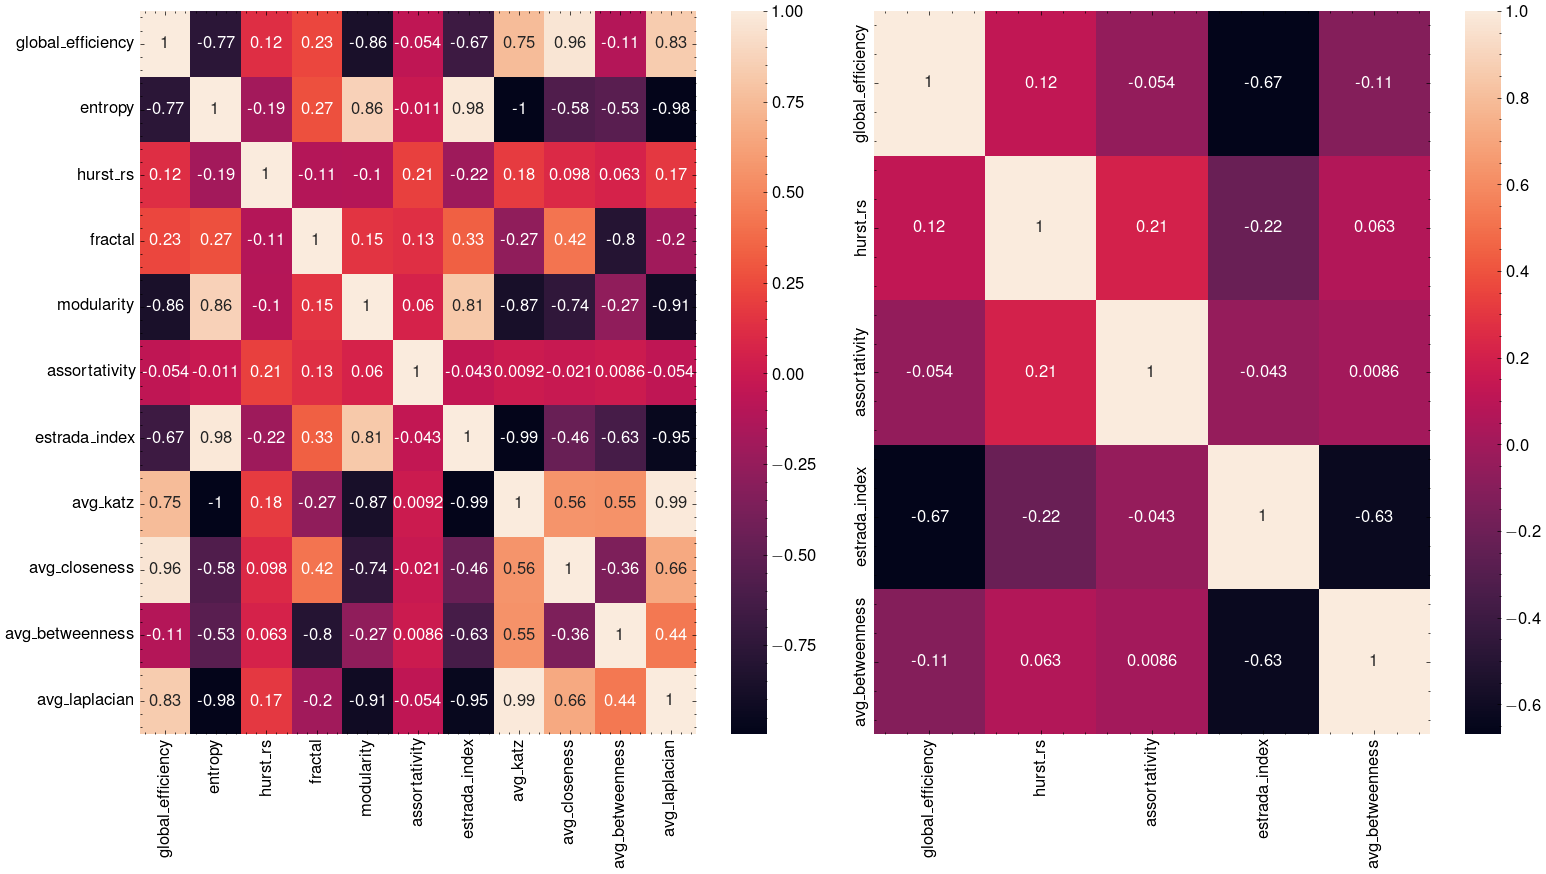

In [71]:
df = results["df0"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))

sns.heatmap(df[METRIC_COLUMNS].corr(), annot=True, ax=ax1)

X = df[METRIC_COLUMNS].values
y = df["intensity"].values
features = df[METRIC_COLUMNS].columns.tolist()

# Apply the SelectNonCollinear feature selector to remove highly collinear features
selector = SelectNonCollinear(0.7)
selector.fit(X)
mask = selector.get_support()
df2 = pd.DataFrame(X[:, mask], columns=np.array(features)[mask])
sns.heatmap(df2.corr(), annot=True, ax=ax2)

fig.tight_layout()
plt.show()

In [72]:
x1 = df2.astype(float).values
y1 = (
    df["intensity"]
    .replace(
        ["G1", "G2", "G3", "G4", "G5", "Unknown", np.nan, "G4/G5", "G3/G4"],
        [1, 2, 3, 4, 5, 0, 0, 4.5, 3.5],
    )
    .astype(float)
    .values
)

results_no_colinear = get_model_summary_statistics(x1, y1)

print(df2.columns.tolist())
display(results["model"].summary2().tables[1], results_no_colinear["summary"])

['global_efficiency', 'hurst_rs', 'assortativity', 'estrada_index', 'avg_betweenness']


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
const,115.497095,88.319511,1.307719,0.204470,-67.666360,298.660549
x1,-87.544551,69.148033,-1.266045,0.218740,-230.948793,55.859692
x2,-12.184421,12.100803,-1.006910,0.324925,-37.279951,12.911109
x3,-2.550183,1.070844,-2.381471,0.026323,-4.770977,-0.329389
x4,-0.178412,1.313078,-0.135873,0.893157,-2.901569,2.544745
x5,11.714764,8.888214,1.318011,0.201060,-6.718264,30.147792
x6,3.858060,1.457031,2.647892,0.014695,0.836363,6.879756
x7,-0.108051,0.086797,-1.244867,0.226279,-0.288058,0.071956
x8,-513.779057,283.499301,-1.812276,0.083615,-1101.720621,74.162508
x9,68.780042,41.815367,1.644851,0.114215,-17.939721,155.499804


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
const,-3.780852,7.103507,-0.532252,0.598750,-18.331728,10.770023
x1,13.903343,9.758464,1.424747,0.165282,-6.085964,33.892651
x2,-1.663356,0.978528,-1.699855,0.100243,-3.667779,0.341068
x3,1.675007,0.944382,1.773653,0.086998,-0.259473,3.609486
x4,0.033725,0.033530,1.005812,0.323119,-0.034958,0.102407
x5,16.626537,12.191291,1.363804,0.183493,-8.346191,41.599264
